In [3]:
import pandas as pd
from pathlib import Path

# ---------- 1. Read core datasets ----------

base_path = Path("D:/finance/data")  # change this

nsdl = pd.read_csv(base_path / "nsdl_combined_manual.csv")
green = pd.read_csv(base_path / "indian_green_stocks.csv", parse_dates=["date"])
controls = pd.read_csv(base_path / "control_variables_wide_format.csv", parse_dates=["date"])

# ---------- 2. Basic cleaning / standardisation ----------

# NSDL: standardise sector/instrument text, ensure date
nsdl["report_date"] = pd.to_datetime(nsdl["report_date"])
for col in ["sector", "instrument"]:
    if col in nsdl.columns:
        nsdl[col] = nsdl[col].str.strip()

# Green stocks: sort, drop obvious duplicates, keep needed cols
green = (
    green
    .drop_duplicates(subset=["ticker", "date"])
    .sort_values(["ticker", "date"])
)

# Controls: ensure unique dates, sort
controls = (
    controls
    .drop_duplicates(subset=["date"])
    .sort_values("date")
)

# ---------- 3. Quick sanity checks (outputs) ----------

print("NSDL head:")
print(nsdl.head())

print("\nGreen stocks head:")
print(green.head())

print("\nControls head:")
print(controls.head())

print("\nNSDL date range:", nsdl["report_date"].min(), "to", nsdl["report_date"].max())
print("Green stocks date range:", green["date"].min(), "to", green["date"].max())
print("Controls date range:", controls["date"].min(), "to", controls["date"].max())


NSDL head:
         0                               1                           2  \
0      NaN                             NaN  AUC as on October 31, 2025   
1      NaN                             NaN                  IN INR Cr.   
2      NaN                             NaN                      Equity   
3  Sr. No.                         Sectors                      Equity   
4        1  Automobile and Auto Components                      560155   

                            3                           4  \
0  AUC as on October 31, 2025  AUC as on October 31, 2025   
1                  IN INR Cr.                  IN INR Cr.   
2                        Debt                        Debt   
3          Debt General Limit                    Debt VRR   
4                         477                         220   

                            5                           6  \
0  AUC as on October 31, 2025  AUC as on October 31, 2025   
1                  IN INR Cr.                  IN INR C

In [4]:
import pandas as pd

# 1. Equal-weighted daily return of all green stocks
green_portfolio = (
    green
    .groupby("date", as_index=False)["log_return"]
    .mean()
    .rename(columns={"log_return": "green_eq_log_ret"})
)

print(green_portfolio.head())
print("Green portfolio date range:", green_portfolio["date"].min(), "to", green_portfolio["date"].max())


                       date  green_eq_log_ret
0 2020-01-01 00:00:00+05:30               NaN
1 2020-01-02 00:00:00+05:30          0.024312
2 2020-01-03 00:00:00+05:30          0.027755
3 2020-01-06 00:00:00+05:30          0.011209
4 2020-01-07 00:00:00+05:30          0.016773
Green portfolio date range: 2020-01-01 00:00:00+05:30 to 2025-12-04 00:00:00+05:30


In [5]:
import pandas as pd

# 1. Keep equity flows only (you can change this filter)
equity_flows = nsdl[nsdl["instrument"].str.contains("Equity", case=False)]

# 2. Example: Power sector fortnightly FPI equity flows
power_flows = (
    equity_flows[equity_flows["sector"].str.contains("Power", case=False)]
    .groupby("report_date", as_index=False)["net_investment_inr_cr"]
    .sum()
    .rename(columns={"net_investment_inr_cr": "power_fpi_flow_inr_cr"})
    .sort_values("report_date")
)

print(power_flows.head())
print("Power flows dates:", power_flows["report_date"].min(), "to", power_flows["report_date"].max())


KeyError: 'instrument'

In [6]:
print(nsdl.columns.tolist())


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', 'report_date', 'source_url']


In [7]:
# 1. Identify numeric columns only (0–97)
num_cols = [c for c in nsdl.columns if c not in ["report_date", "source_url"]]

# 2. Simple aggregate: sum across all numeric cols = total FPI-related amount per report_date
nsdl_total = (
    nsdl
    .assign(report_date=pd.to_datetime(nsdl["report_date"]))
    .groupby("report_date", as_index=False)[num_cols]
    .sum()
)

# 3. Example: create one scalar proxy per date by summing all numeric columns
nsdl_total["fpi_total_proxy"] = nsdl_total[num_cols].sum(axis=1)

print(nsdl_total[["report_date", "fpi_total_proxy"]].head())


  report_date                                    fpi_total_proxy
0  2025-08-31  Sr. No.123456789101112131415161718192021222324...
1  2025-09-30  Sr. No.123456789101112131415161718192021222324...
2  2025-10-15  Sr. No.123456789101112131415161718192021222324...
3  2025-10-31  Sr. No.123456789101112131415161718192021222324...
4  2025-11-15  Sr. No.123456789101112131415161718192021222324...


In [8]:
# Assuming you already have:
# green_portfolio: date, green_eq_log_ret
# controls: date + wide control columns

# 1. Inner merge on date
panel = pd.merge(
    green_portfolio,
    controls,
    on="date",
    how="inner"
).sort_values("date")

print(panel.head())
print(panel.columns.tolist())


ValueError: You are trying to merge on datetime64[ns, UTC+05:30] and object columns for key 'date'. If you wish to proceed you should use pd.concat

In [10]:
# 1) First parse to UTC-aware, then strip tz
controls["date"] = pd.to_datetime(controls["date"], utc=True, errors="coerce")
controls["date"] = controls["date"].dt.tz_localize(None)

# 2) Make green_portfolio date tz-naive too
green_portfolio["date"] = pd.to_datetime(green_portfolio["date"]).dt.tz_localize(None)

# 3) Merge
panel = (
    pd.merge(green_portfolio, controls, on="date", how="inner")
      .sort_values("date")
)

print(panel.head())
print(panel.dtypes["date"])


        date  green_eq_log_ret  close_BZ_F  close_CL_F  close_CNYUSD_X  \
0 2020-01-01               NaN         NaN         NaN        0.143631   
1 2020-01-02          0.024312         NaN         NaN        0.143633   
2 2020-01-03          0.027755         NaN         NaN        0.143608   
3 2020-01-06          0.011209         NaN         NaN        0.143585   
4 2020-01-07          0.016773         NaN         NaN        0.143379   

   close_EURUSD_X  close_GBPUSD_X  close_GC_F  close_INRUSD_X  close_JPYUSD_X  \
0        1.122083        1.326260         NaN        0.014030        0.009201   
1        1.122083        1.325030         NaN        0.014080        0.009199   
2        1.117144        1.315270         NaN        0.014003        0.009213   
3        1.116196        1.308010         NaN        0.013941        0.009262   
4        1.119799        1.317003         NaN        0.013930        0.009225   

   ...  volume_FTSE  volume_GSPC  volume_IXIC  volume_N225  volume_N

In [16]:
import pandas as pd
from pathlib import Path

base_path = Path()  # change this
clean_nsdl_path = base_path / "nsdl_flows_clean_sample.csv"

# 1) Define the columns we need for research
cols = ["report_date", "sector", "instrument",
        "net_investment_inr_cr", "auc_inr_cr"]

# 2) Create an empty DataFrame with those columns
fpi_template = pd.DataFrame(columns=cols)

# 3) Save the empty template CSV
fpi_template.to_csv(clean_nsdl_path, index=False)

print(f"Template created at: {clean_nsdl_path}")


Template created at: nsdl_flows_clean_sample.csv


In [18]:
import pandas as pd
from pathlib import Path

base_path = Path()  # CHANGE THIS

# 1. Load your existing data
green = pd.read_csv(base_path / "indian_green_stocks.csv", parse_dates=["date"])
controls = pd.read_csv(base_path / "control_variables_wide_format.csv")
controls["date"] = pd.to_datetime(controls["date"], utc=True, errors="coerce").dt.tz_localize(None)

# 2. Green equal‑weighted portfolio
green["date"] = green["date"].dt.tz_localize(None)
green_portfolio = (
    green.groupby("date", as_index=False)["log_return"]
         .mean()
         .rename(columns={"log_return": "green_eq_log_ret"})
)

# 3. Merge with controls
panel = (
    pd.merge(green_portfolio, controls, on="date", how="inner")
      .sort_values("date")
)

# 4. Load CLEAN NSDL sample (you create this once)
fpi = pd.read_csv(base_path / "nsdl_flows_clean_sample.csv")
fpi["report_date"] = pd.to_datetime(fpi["report_date"])

# example: equity flows only, aggregated by date
fpi_eq = (
    fpi[fpi["instrument"].str.contains("Equity", case=False)]
    .groupby("report_date", as_index=False)["net_investment_inr_cr"]
    .sum()
    .rename(columns={"report_date": "date",
                     "net_investment_inr_cr": "fpi_equity_flow_inr_cr"})
)

# 5. Merge FPI into panel (note: FPI is likely lower‑frequency)
panel = pd.merge(panel, fpi_eq, on="date", how="left")

print(panel.head())


        date  green_eq_log_ret  close_BZ_F  close_CL_F  close_CNYUSD_X  \
0 2020-01-01               NaN         NaN         NaN        0.143631   
1 2020-01-02          0.024312         NaN         NaN        0.143633   
2 2020-01-03          0.027755         NaN         NaN        0.143608   
3 2020-01-06          0.011209         NaN         NaN        0.143585   
4 2020-01-07          0.016773         NaN         NaN        0.143379   

   close_EURUSD_X  close_GBPUSD_X  close_GC_F  close_INRUSD_X  close_JPYUSD_X  \
0        1.122083        1.326260         NaN        0.014030        0.009201   
1        1.122083        1.325030         NaN        0.014080        0.009199   
2        1.117144        1.315270         NaN        0.014003        0.009213   
3        1.116196        1.308010         NaN        0.013941        0.009262   
4        1.119799        1.317003         NaN        0.013930        0.009225   

   ...  volume_GSPC  volume_IXIC  volume_N225  volume_NSEBANK  volum

In [22]:
print("panel columns and dtypes:")
print(panel.dtypes)

print("\nFirst few rows of panel:")
print(panel.head())


panel columns and dtypes:
date                      datetime64[ns]
green_eq_log_ret                 float64
close_BZ_F                       float64
close_CL_F                       float64
close_CNYUSD_X                   float64
                               ...      
volume_RUT                       float64
volume_STOXX50E                  float64
volume_VIX                       float64
volume_VXEEM                     float64
fpi_equity_flow_inr_cr            object
Length: 105, dtype: object

First few rows of panel:
        date  green_eq_log_ret  close_BZ_F  close_CL_F  close_CNYUSD_X  \
0 2020-01-01               NaN         NaN         NaN        0.143631   
1 2020-01-02          0.024312         NaN         NaN        0.143633   
2 2020-01-03          0.027755         NaN         NaN        0.143608   
3 2020-01-06          0.011209         NaN         NaN        0.143585   
4 2020-01-07          0.016773         NaN         NaN        0.143379   

   close_EURUSD_X  close_

In [26]:
import numpy as np

reg = panel.dropna(subset=["green_eq_log_ret"]).copy()
print("reg shape:", reg.shape)

regressor = "close_NSEI"  # keep this
print("regressor in columns?", regressor in reg.columns)
print("reg[regressor].dtype:", reg[regressor].dtype)

X = reg[[regressor]].astype(float)
X = sm.add_constant(X, has_constant="add")
y = reg["green_eq_log_ret"].astype(float)

print("X values:\n", X.head())
print("y values:\n", y.head())
print("X.shape:", X.shape, "y.shape:", y.shape)
print("Any NaNs in X?", np.isnan(X).any())
print("Any NaNs in y?", np.isnan(y).any())


reg shape: (602, 105)
regressor in columns? True
reg[regressor].dtype: float64
X values:
    const  close_NSEI
1    1.0         NaN
2    1.0         NaN
3    1.0         NaN
4    1.0         NaN
5    1.0         NaN
y values:
 1    0.024312
2    0.027755
3    0.011209
4    0.016773
5   -0.019441
Name: green_eq_log_ret, dtype: float64
X.shape: (602, 2) y.shape: (602,)
Any NaNs in X? const         False
close_NSEI     True
dtype: bool
Any NaNs in y? False


In [27]:
import statsmodels.api as sm

reg = panel.dropna(subset=["green_eq_log_ret"]).copy()

regressor = "close_CNYUSD_X"  # this one clearly has numbers
X = reg[[regressor]].astype(float)
X = sm.add_constant(X, has_constant="add")
y = reg["green_eq_log_ret"].astype(float)

print("X.head():")
print(X.head())
print("Any NaNs in X?\n", X.isna().any())

model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())


X.head():
   const  close_CNYUSD_X
1    1.0        0.143633
2    1.0        0.143608
3    1.0        0.143585
4    1.0        0.143379
5    1.0        0.144001
Any NaNs in X?
 const             False
close_CNYUSD_X    False
dtype: bool
                            OLS Regression Results                            
Dep. Variable:       green_eq_log_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5234
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.470
Time:                        16:45:44   Log-Likelihood:                 1581.9
No. Observations:                 602   AIC:                            -3160.
Df Residuals:                     600   BIC:                            -3151.
Df Model:                           1                                         
Covariance Type:            nonrobust                

In [30]:
import numpy as np
import statsmodels.api as sm

reg = panel.copy()

# 1) Choose a regressor that has numbers (e.g. close_CNYUSD_X)
regressor = "close_CNYUSD_X"

# 2) Keep only rows where BOTH y and X are non-missing
mask = reg["green_eq_log_ret"].notna() & reg[regressor].notna()
reg2 = reg.loc[mask, ["green_eq_log_ret", regressor]]

print("reg2 shape:", reg2.shape)

# 3) Build X and y
y = reg2["green_eq_log_ret"].astype(float)
X = reg2[[regressor]].astype(float)
X = sm.add_constant(X, has_constant="add")

print("Any NaNs left in X?", X.isna().any())
print("Any NaNs left in y?", y.isna().any())

# 4) Now run OLS with default missing handling
model = sm.OLS(y, X).fit()
print(model.summary())


reg2 shape: (602, 2)
Any NaNs left in X? const             False
close_CNYUSD_X    False
dtype: bool
Any NaNs left in y? False
                            OLS Regression Results                            
Dep. Variable:       green_eq_log_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5234
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.470
Time:                        16:48:53   Log-Likelihood:                 1581.9
No. Observations:                 602   AIC:                            -3160.
Df Residuals:                     600   BIC:                            -3151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]


In [32]:
import numpy as np
import statsmodels.api as sm

# 1) Pick some controls that actually exist
controls = ["return_NSEI", "return_GSPC"]  # change names to real return_* cols in panel

# 2) Build a DataFrame with y + X and drop rows with any NaNs
cols = ["green_eq_log_ret"] + [c for c in controls if c in panel.columns]
reg2 = panel[cols].dropna()

# 3) Keep only numeric columns for X
X = reg2.drop(columns=["green_eq_log_ret"])
X = X.loc[:, [np.issubdtype(X[c].dtype, np.number) for c in X.columns]]

# 4) Guard: if X or y is empty, skip OLS instead of crashing
if X.shape[0] == 0 or X.shape[1] == 0:
    print("No valid rows or regressors available after dropping NaNs; OLS skipped.")
else:
    y = reg2["green_eq_log_ret"].astype(float)
    X = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, X).fit()
    print(model.summary())


No valid rows or regressors available after dropping NaNs; OLS skipped.


In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ---- 0. Assume panel already created as before ----
# panel has: date, green_eq_log_ret, many controls, fpi_equity_flow_inr_cr (object)

# ---------------- 1. Descriptive stats for green portfolio ---------------- #

# Full-sample summary
desc = panel["green_eq_log_ret"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
print("Green portfolio daily log-return summary:")
print(desc)

# Annualised mean and volatility (assuming 252 trading days)
mu_daily = panel["green_eq_log_ret"].mean()
sigma_daily = panel["green_eq_log_ret"].std()
mu_annual = mu_daily * 252
sigma_annual = sigma_daily * np.sqrt(252)

print("\nAnnualised mean return:", mu_annual)
print("Annualised volatility:", sigma_annual)

# ---------------- 2. Baseline risk-exposure regressions ---------------- #

# Example controls that clearly exist and have data; adjust if needed
controls_candidate = [
    "close_CNYUSD_X",
    "close_EURUSD_X",
    "close_GSPC",
    "close_BZ_F",
]

# Keep only those that are present and numeric
controls = [
    c for c in controls_candidate
    if c in panel.columns and np.issubdtype(panel[c].dtype, np.number)
]

print("\nUsing these controls:", controls)

# Build regression dataset: drop rows with any NaNs in y or chosen X
cols_for_reg = ["green_eq_log_ret"] + controls
reg = panel[cols_for_reg].dropna()

print("Regression sample size:", reg.shape[0])

if reg.shape[0] > 0 and len(controls) > 0:
    y = reg["green_eq_log_ret"].astype(float)
    X = sm.add_constant(reg[controls].astype(float), has_constant="add")
    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
    print(model.summary())
else:
    print("No valid rows or regressors; cannot run baseline regression.")


Green portfolio daily log-return summary:
count    602.000000
mean       0.000492
std        0.017504
min       -0.095172
1%        -0.054139
5%        -0.027120
50%        0.001791
95%        0.025200
99%        0.038276
max        0.061843
Name: green_eq_log_ret, dtype: float64

Annualised mean return: 0.12397536438463619
Annualised volatility: 0.27786559096520985

Using these controls: ['close_CNYUSD_X', 'close_EURUSD_X', 'close_GSPC', 'close_BZ_F']
Regression sample size: 0
No valid rows or regressors; cannot run baseline regression.


In [34]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- 1. Cumulative return of green portfolio --- #
green = panel[["date", "green_eq_log_ret"]].dropna().copy()
green = green.sort_values("date")
green["cum_return"] = (1 + green["green_eq_log_ret"]).cumprod() - 1

print("Final cumulative return:", green["cum_return"].iloc[-1])

# --- 2. One-factor regression with a control that overlaps --- #
regressor = "close_CNYUSD_X"
mask = panel["green_eq_log_ret"].notna() & panel[regressor].notna()
reg2 = panel.loc[mask, ["green_eq_log_ret", regressor]]

y = reg2["green_eq_log_ret"].astype(float)
X = sm.add_constant(reg2[[regressor]].astype(float))
model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
print(model.summary())


Final cumulative return: 0.22505756955597755
                            OLS Regression Results                            
Dep. Variable:       green_eq_log_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5458
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.460
Time:                        16:57:13   Log-Likelihood:                 1581.9
No. Observations:                 602   AIC:                            -3160.
Df Residuals:                     600   BIC:                            -3151.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

Saved: green_returns_timeseries.png, green_cumulative_return.png, green_return_histogram.png


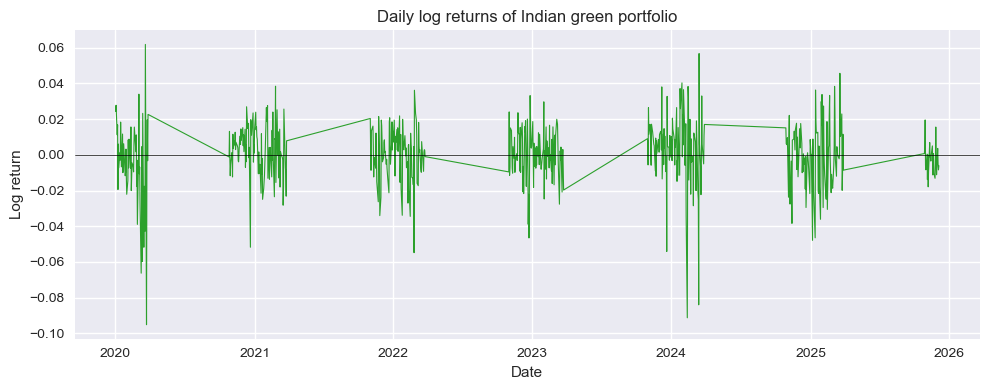

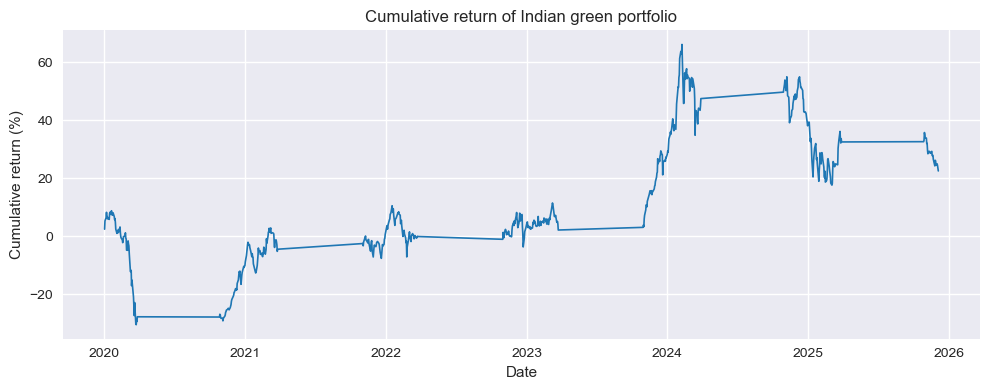

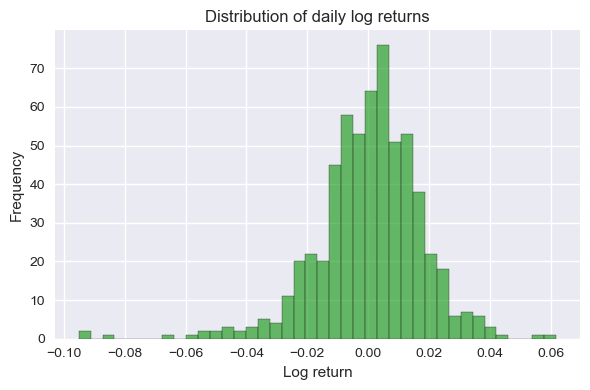

In [35]:
plt.style.use("seaborn-v0_8")

# --- A. Time series of green portfolio daily returns --- #
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(green["date"], green["green_eq_log_ret"], color="tab:green", linewidth=0.8)
ax.axhline(0, color="black", linewidth=0.5)
ax.set_title("Daily log returns of Indian green portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Log return")
fig.tight_layout()
plt.savefig("green_returns_timeseries.png", dpi=300)

# --- B. Cumulative return of green portfolio --- #
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(green["date"], green["cum_return"] * 100, color="tab:blue", linewidth=1.2)
ax.set_title("Cumulative return of Indian green portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative return (%)")
fig.tight_layout()
plt.savefig("green_cumulative_return.png", dpi=300)

# --- C. Histogram of daily returns --- #
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(green["green_eq_log_ret"], bins=40, color="tab:green", edgecolor="black", alpha=0.7)
ax.set_title("Distribution of daily log returns")
ax.set_xlabel("Log return")
ax.set_ylabel("Frequency")
fig.tight_layout()
plt.savefig("green_return_histogram.png", dpi=300)

print("Saved: green_returns_timeseries.png, green_cumulative_return.png, green_return_histogram.png")


      lb_stat  lb_pvalue
1    0.559127   0.454612
5    6.551703   0.256171
10  17.010207   0.074138


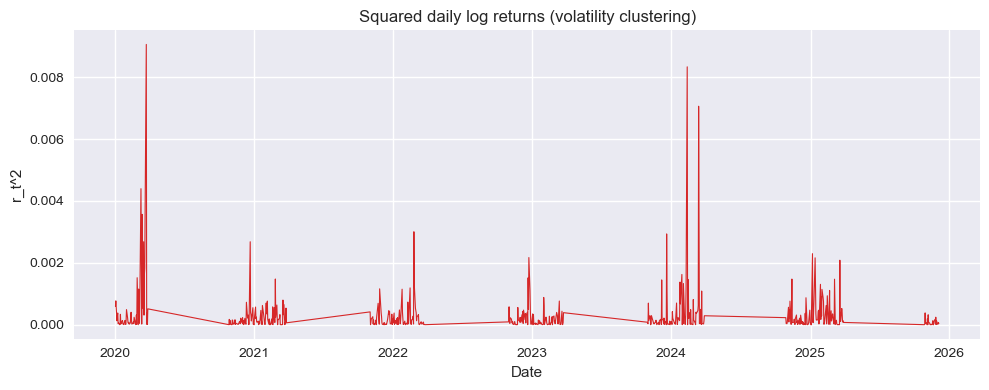

In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

r = panel["green_eq_log_ret"].dropna()

# A. Ljung–Box test for autocorrelation
lb = acorr_ljungbox(r, lags=[1, 5, 10], return_df=True)
print(lb)

# B. Plot squared returns over time (volatility clustering)
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(panel["date"].loc[r.index], r**2, color="tab:red", linewidth=0.8)
ax.set_title("Squared daily log returns (volatility clustering)")
ax.set_xlabel("Date"); ax.set_ylabel("r_t^2")
fig.tight_layout()
plt.savefig("green_volatility_clustering.png", dpi=300)


Max drawdown: -0.3611069582890043


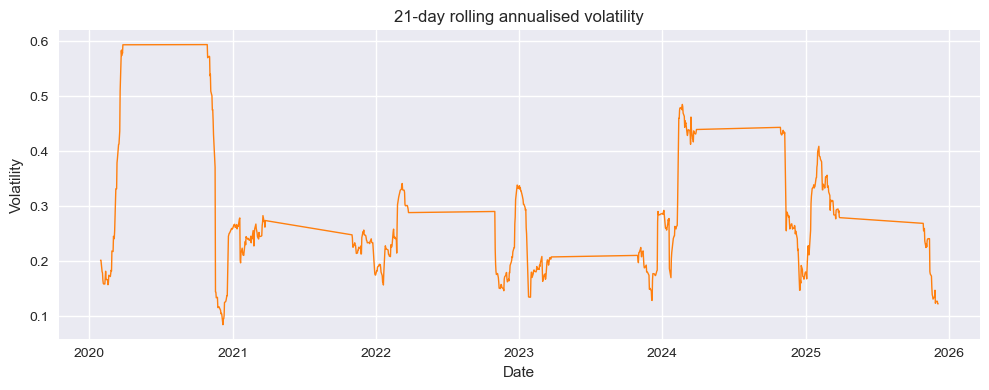

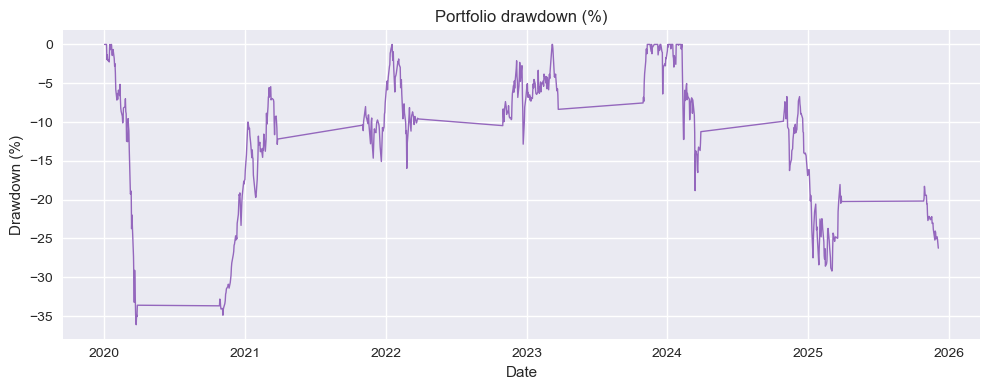

In [37]:
# A. Rolling 21-day volatility
roll = r.rolling(21).std() * (252**0.5)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(panel["date"].loc[roll.index], roll, color="tab:orange", linewidth=1)
ax.set_title("21-day rolling annualised volatility")
ax.set_xlabel("Date"); ax.set_ylabel("Volatility")
fig.tight_layout()
plt.savefig("green_rolling_vol.png", dpi=300)

# B. Max drawdown
cum = (1 + r).cumprod()
running_max = cum.cummax()
drawdown = cum / running_max - 1
max_dd = drawdown.min()
print("Max drawdown:", max_dd)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(panel["date"].loc[drawdown.index], drawdown * 100, color="tab:purple", linewidth=1)
ax.set_title("Portfolio drawdown (%)")
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown (%)")
fig.tight_layout()
plt.savefig("green_drawdown.png", dpi=300)


In [39]:
# 1. Check if return_NSEI exists and has overlap with green_eq_log_ret
print("return_NSEI in panel?", "return_NSEI" in panel.columns)
if "return_NSEI" in panel.columns:
    mask = panel["green_eq_log_ret"].notna() & panel["return_NSEI"].notna()
    reg3 = panel.loc[mask, ["green_eq_log_ret", "return_NSEI"]]
    print("reg3.shape:", reg3.shape)
else:
    print("No return_NSEI column, CAPM beta not estimable yet.")


return_NSEI in panel? True
reg3.shape: (0, 2)


In [42]:
import numpy as np
import pandas as pd
import yfinance as yf

# 1. Download NIFTY 50 index from Yahoo Finance
nse = yf.download("^NSEI", start="2019-12-01", end="2025-12-31")  # adjust dates if needed

# 2. Keep close and compute daily log returns
nse = nse[["Close"]].rename(columns={"Close": "close_NSEI"})
nse = nse.sort_index()
nse["return_NSEI"] = np.log(nse["close_NSEI"] / nse["close_NSEI"].shift(1))

# 3. Move index to a 'date' column
nse = nse.reset_index().rename(columns={"Date": "date"})

# 4. Merge into your existing panel on date
panel = panel.merge(nse[["date", "return_NSEI"]], on="date", how="left")

print(panel[["date", "green_eq_log_ret", "return_NSEI"]].head())
print(panel[["green_eq_log_ret", "return_NSEI"]].notna().all(axis=1).sum(),
      "rows with overlap for CAPM regression")


[*********************100%***********************]  1 of 1 completed


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [44]:
print("nse columns:", nse.columns.tolist())
print("panel columns (tail):", panel.columns[-10:].tolist())


nse columns: ['date', 'close_NSEI', 'return_NSEI']
panel columns (tail): ['volume_IXIC', 'volume_N225', 'volume_NSEBANK', 'volume_NSEI', 'volume_RUT', 'volume_STOXX50E', 'volume_VIX', 'volume_VXEEM', 'fpi_equity_flow_inr_cr', 'return_NSEI_y']


In [45]:
import numpy as np
import pandas as pd
import yfinance as yf

nse = yf.download("^NSEI", start="2019-12-01", end="2025-12-31")

# Flatten columns if needed
if isinstance(nse.columns, pd.MultiIndex):
    nse.columns = [c[0] for c in nse.columns]
print("After flattening, nse columns:", nse.columns.tolist())

# Keep 'Close' and compute return
nse = nse[["Close"]].rename(columns={"Close": "close_NSEI"})
nse = nse.sort_index()
nse["return_NSEI"] = np.log(nse["close_NSEI"] / nse["close_NSEI"].shift(1))

nse = nse.reset_index().rename(columns={"Date": "date"})
print("nse columns after processing:", nse.columns.tolist())
print(nse.head())


[*********************100%***********************]  1 of 1 completed

After flattening, nse columns: ['Close', 'High', 'Low', 'Open', 'Volume']
nse columns after processing: ['date', 'close_NSEI', 'return_NSEI']
        date    close_NSEI  return_NSEI
0 2019-12-02  12048.200195          NaN
1 2019-12-03  11994.200195    -0.004492
2 2019-12-04  12043.200195     0.004077
3 2019-12-05  12018.400391    -0.002061
4 2019-12-06  11921.500000    -0.008095


In [46]:
panel["date"] = pd.to_datetime(panel["date"]).dt.tz_localize(None)
nse["date"]   = pd.to_datetime(nse["date"]).dt.tz_localize(None)

panel = panel.merge(nse[["date", "return_NSEI"]], on="date", how="left")
print("'return_NSEI' in panel?", "return_NSEI" in panel.columns)


'return_NSEI' in panel? True


In [47]:
overlap = panel[["green_eq_log_ret", "return_NSEI"]].notna().all(axis=1).sum()
print("Overlapping rows for CAPM:", overlap)


Overlapping rows for CAPM: 601


In [48]:
import statsmodels.api as sm

mask = panel["green_eq_log_ret"].notna() & panel["return_NSEI"].notna()
reg_capm = panel.loc[mask, ["green_eq_log_ret", "return_NSEI"]]

print("CAPM sample size:", reg_capm.shape[0])

if reg_capm.shape[0] > 0:
    y = reg_capm["green_eq_log_ret"].astype(float)
    X = sm.add_constant(reg_capm[["return_NSEI"]].astype(float))
    capm = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
    print(capm.summary())
else:
    print("No overlapping rows for CAPM regression.")


CAPM sample size: 601
                            OLS Regression Results                            
Dep. Variable:       green_eq_log_ret   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     154.1
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           1.22e-31
Time:                        23:00:05   Log-Likelihood:                 1727.8
No. Observations:                 601   AIC:                            -3452.
Df Residuals:                     599   BIC:                            -3443.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0006      